# Defining problem to solve

Given a dataset of transactions (customer-product pairs that resulted in purchases), I want to find other customer-product pairs that are likely to be purchased.  More specifically, I'm trying to figure out what customers will be interested in purchasing next week.

The dataset in use is provided by Kaggle here (https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data).

Due to computing power limitations, I have chosen not to use the provided image data in my model, but have instead chosen to use tabular data exclusively.

# Import libraries

In [ ]:
!pip install plot_keras_history
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

from datetime import datetime
from scipy import stats
import numpy as np
import pandas as pd
import keras
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import json
import numexpr as ne
from math import sqrt
import time

from keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Add, Embedding, Dropout, Flatten, LocallyConnected1D, BatchNormalization, Dot, Reshape, Concatenate
from keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint

import os
from sklearn import preprocessing

from google.colab import drive
drive.mount('/content/drive')

# Extracts transactions file from google drive.  Without this extraction, 
# for some reason gDrive clips the .csv file so that I lose transactions data.

from zipfile import ZipFile 
file = "drive/MyDrive/transactions_train.csv.zip"
with ZipFile(file, 'r') as zip: 
    zip.extractall() 

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.35-py3-none-any.whl size=9091 sha256=4dece0ba3f1c42487a0ea5f26a4347e617f5e25e5354bb4054acd8c8446368bf
  Stored in directory: /root/.cache/pip/wheels/40/92/fd/d7d02562f5312ec89748f7ca7e16d1f1cac44719a551242bf2
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.33-py3-none-any.whl size=8285 sha256=9efdf8c9e6fbc58a4ccc67b84e56ef784bb4efe0d9df0f2fd78ddbc0fb4967e9
  Stored in directory: /root/.cache/pip/wheels/66/ab/57/d00b27746f59b194d2b311d076da744dd3fc1f6ceb8574e9ae
  Created wheel for compress-json: filename=compress_json-1.0.5-py3-none-any.whl size=4899 sha256=359fb099afe999ac42839318b7d43f3f5f818e97340575833534843b759c696d
  Stored in directory: /root/.cache/pip/wheels/9d/c9/7d/7840b772f45f7870c08cb0df4eefa994af4208bbc046856b41
Successfully built plot-keras-history sanitize-ml-labels compress-json
Mounted at /content/drive


In [ ]:
# Number of most popular products to make predictions from.
pred_len = 10000

# Reading in data

In [69]:
# Read data into pandas dataframes
transactions = pd.read_csv("transactions_train.csv")
articles = pd.read_csv("drive/MyDrive/articles.csv")
customers = pd.read_csv("drive/MyDrive/customers.csv")

# Performing basic data summarization and preparation

In [70]:
articles.nunique()

article_id                      105542
product_code                     47224
prod_name                        45875
product_type_no                    132
product_type_name                  131
product_group_name                  19
graphical_appearance_no             30
graphical_appearance_name           30
colour_group_code                   50
colour_group_name                   50
perceived_colour_value_id            8
perceived_colour_value_name          8
perceived_colour_master_id          20
perceived_colour_master_name        20
department_no                      299
department_name                    250
index_code                          10
index_name                          10
index_group_no                       5
index_group_name                     5
section_no                          57
section_name                        56
garment_group_no                    21
garment_group_name                  21
detail_desc                      43404
dtype: int64

In [71]:
customers.nunique()

customer_id               1371980
FN                              1
Active                          1
club_member_status              3
fashion_news_frequency          4
age                            84
postal_code                352899
dtype: int64

In [72]:
# View basic structure of transactions data
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [73]:
encoders = {}

cust_encoder = preprocessing.LabelEncoder()
        
cust_encoder = cust_encoder.fit(customers["customer_id"].values)

print(len(cust_encoder.classes_))

encoders["customer_id"] = cust_encoder

transactions["customer_id"] = cust_encoder.transform(transactions["customer_id"].values)
customers["customer_id"] = cust_encoder.transform(customers["customer_id"].values)

1371980


In [74]:
counts_dict = transactions["article_id"].value_counts().nlargest(n=pred_len).to_dict()
trans_subset = transactions[transactions["article_id"].isin(counts_dict.keys())]

In [75]:
articles_subset = articles[["article_id", "product_type_name", 
                            "graphical_appearance_name", "colour_group_name", 
                            "perceived_colour_value_name", 
                            "perceived_colour_master_name", "department_name", 
                            "index_name", "index_group_name", "section_name", 
                            "garment_group_name"]]

In [76]:
trans_subset.shape
transactions = pd.merge(articles_subset, trans_subset, on=['article_id'], how="right")
transactions = pd.merge(transactions, customers[["customer_id", "age", "postal_code"]], on=["customer_id"], how="left")

In [77]:
transactions.dtypes

article_id                        int64
product_type_name                object
graphical_appearance_name        object
colour_group_name                object
perceived_colour_value_name      object
perceived_colour_master_name     object
department_name                  object
index_name                       object
index_group_name                 object
section_name                     object
garment_group_name               object
t_dat                            object
customer_id                       int64
price                           float64
sales_channel_id                  int64
age                             float64
postal_code                      object
dtype: object

In [78]:
transactions['t_dat'] =  pd.to_datetime(transactions['t_dat'])

In [79]:
# Get number of unique values in each column for all of our data.
# This will be helpful later.

t_count = transactions.nunique()
transactions.shape

c_count = customers.nunique()
customers.shape

a_count = articles.nunique()

In [80]:
t_count

article_id                        10000
product_type_name                    82
graphical_appearance_name            28
colour_group_name                    49
perceived_colour_value_name           8
perceived_colour_master_name         18
department_name                     119
index_name                            8
index_group_name                      5
section_name                         39
garment_group_name                   19
t_dat                               734
customer_id                     1217586
price                              6633
sales_channel_id                      2
age                                  84
postal_code                      341486
dtype: int64

In [81]:
c_count

customer_id               1371980
FN                              1
Active                          1
club_member_status              3
fashion_news_frequency          4
age                            84
postal_code                352899
dtype: int64

In [82]:
a_count

article_id                      105542
product_code                     47224
prod_name                        45875
product_type_no                    132
product_type_name                  131
product_group_name                  19
graphical_appearance_no             30
graphical_appearance_name           30
colour_group_code                   50
colour_group_name                   50
perceived_colour_value_id            8
perceived_colour_value_name          8
perceived_colour_master_id          20
perceived_colour_master_name        20
department_no                      299
department_name                    250
index_code                          10
index_name                          10
index_group_no                       5
index_group_name                     5
section_no                          57
section_name                        56
garment_group_no                    21
garment_group_name                  21
detail_desc                      43404
dtype: int64

# Create LabelEncoders for each categorical column of interest

A label encoder will convert a categorical string to a number, which I can then feed into the Embedding layers in my transformer-based model severals cells down.

In [83]:
for column in transactions.columns:
    
    if column not in ["age", "price", "customer_id", "postal_code", "t_dat"]:
        print(column)

        le = preprocessing.LabelEncoder()
        le = le.fit(transactions[column].values)

        transactions[column] = le.transform(transactions[column].values)
        
        encoders[column] = le



le = preprocessing.LabelEncoder()
le = le.fit(customers["postal_code"].values)

transactions["postal_code"] = le.transform(transactions["postal_code"].values)
encoders["postal_code"] = le

customers["postal_code"] = encoders["postal_code"].transform(customers["postal_code"].values)

article_id
product_type_name
graphical_appearance_name
colour_group_name
perceived_colour_value_name
perceived_colour_master_name
department_name
index_name
index_group_name
section_name
garment_group_name
sales_channel_id


In [84]:
# Drop all but the 10000 most popular products from our dataset and label encode what's left.

articles = articles[articles["article_id"].isin(counts_dict.keys())]

articles["article_id"] = encoders["article_id"].transform(articles["article_id"].values)

articles.set_index("article_id", inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [85]:
# Print the total number of customers that we need to make predictions for
len(cust_encoder.classes_)

1371980

In [86]:
# Find the most common product sold in case we need it later
most_common = transactions["article_id"].value_counts().nlargest(1).index[0]

# Defining model architecture for transformer-based network

This model is based loosely on the encoder half of the transformer network found in "Attention is All You Need" (https://arxiv.org/pdf/1706.03762.pdf).

The biggest difference between this model and their model is that I don't add positional embeddings to each article embedding.

In [ ]:
embedding_dim = 100

customer_id_dim = c_count["customer_id"]
article_id_dim = t_count["article_id"]
product_type_dim = a_count["product_type_name"]
appearance_dim = a_count["graphical_appearance_name"]
colour_dim = a_count["colour_group_name"]
department_dim = a_count["department_name"]
zip_dim = c_count["postal_code"]
month_dim = 4

max_input_len = 16
num_heads = 8
ffn_units = 1024
dropout_rate = 0.1

# Create model architecture (loosely based on Transformer network encoders)

article_id_inp = Input(shape=(max_input_len,))
product_type_inp = Input(shape=(max_input_len,))
appearance_inp = Input(shape=(max_input_len,))
colour_inp = Input(shape=(max_input_len,))
department_inp = Input(shape=(max_input_len,))


price_inp = Input(shape=(max_input_len,))
price = Reshape((max_input_len, 1))(price_inp)

age_inp = Input(shape=(1,))
zip_inp = Input(shape=(1,))

article_emb = Embedding(input_dim=article_id_dim, output_dim=round(sqrt(article_id_dim)))(article_id_inp)
type_emb = Embedding(input_dim=product_type_dim, output_dim=round(sqrt(product_type_dim)))(product_type_inp)
appearance_emb = Embedding(input_dim=appearance_dim, output_dim=round(sqrt(appearance_dim)))(appearance_inp)
colour_emb = Embedding(input_dim=colour_dim, output_dim=round(sqrt(colour_dim)))(colour_inp)
department_emb = Embedding(input_dim=department_dim, output_dim=round(sqrt(department_dim)))(department_inp)
zip_emb = Embedding(input_dim=zip_dim, output_dim=16)(zip_inp)

zip = Flatten()(zip_emb)

concat = Concatenate()([article_emb, type_emb, appearance_emb, colour_emb, department_emb, price])

new_emb_dim = (round(sqrt(article_id_dim)) + round(sqrt(product_type_dim))
              + round(sqrt(appearance_dim)) + round(sqrt(colour_dim))
              + round(sqrt(department_dim)) + 1)

att = MultiHeadAttention(num_heads=num_heads, key_dim=new_emb_dim)(concat, concat)
dropout_1 = Dropout(dropout_rate)(att)
norm_1 = LayerNormalization()(concat + dropout_1)
dense_1 = Dense(ffn_units, activation="relu")(norm_1)
dense_2 = Dense(ffn_units, activation="relu")(dense_1)

norm_2 = BatchNormalization()(dense_2)

dropout_2 = Dropout(dropout_rate)(norm_2)

flat_1 = Flatten()(dropout_2)

concat_2 = Concatenate()([flat_1, age_inp, zip])

dense_3 = Dense(ffn_units, activation="relu")(concat_2)

dense_4 = Dense(ffn_units, activation="relu")(dense_3)

dense_5 = Dense(ffn_units, activation="relu")(dense_4)

norm_2 = LayerNormalization()(dense_3 + dense_5)

dense_6 = Dense(ffn_units, activation="relu")(norm_2)

dense_7 = Dense(ffn_units, activation="relu")(dense_6)

dense_8 = Dense(ffn_units, activation="relu")(dense_7)

norm_3 = LayerNormalization()(dense_3 + dense_8)

out = Dense(article_id_dim + 1, activation="softmax")(norm_3)

model = Model([article_id_inp, product_type_inp, appearance_inp, colour_inp, 
               department_inp, price_inp, age_inp, zip_inp], out)

model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
              metrics=["sparse_categorical_accuracy", "sparse_top_k_categorical_accuracy"])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 16)]         0           []                               
                                                                                              

# Pre-training data processing

My basic training strategy is to feed the model the set of products that each customer has purchased, minus one product.  The goal of this model is to guess which product is missing based on the remaining products.  I think that makes this a sequence agnostic model, though I'm not certain.

In [ ]:
age_dict = pd.Series(customers.age,index=customers.customer_id).to_dict()
zip_dict = pd.Series(customers.postal_code,index=customers.customer_id).to_dict()

In [ ]:
articles_lists = transactions.groupby(['customer_id'])['article_id'].apply(list)
type_lists = transactions.groupby(['customer_id'])['product_type_name'].apply(list)
appearance_lists = transactions.groupby(['customer_id'])['graphical_appearance_name'].apply(list)
colour_lists = transactions.groupby(['customer_id'])['colour_group_name'].apply(list)
department_lists = transactions.groupby(['customer_id'])['department_name'].apply(list)
price_lists = transactions.groupby(['customer_id'])['price'].apply(list)

In [ ]:
art_train = []
type_train = []
app_train = []
colour_train = []
dep_train = []
price_train = []
age_train = []
zip_train = []
y_train = []
custs = []

count = 0

for cust_num in range(c_count["customer_id"]):
  if (cust_num in articles_lists.index):  
    count += 1


    art_set = articles_lists.loc[cust_num]
    type_set = type_lists.loc[cust_num]
    app_set = appearance_lists.loc[cust_num]
    colour_set = colour_lists.loc[cust_num]
    dep_set = department_lists.loc[cust_num]
    price_set = price_lists.loc[cust_num]

    len_set = set([len(art_set),len(type_set),len(app_set),len(colour_set),len(dep_set),len(price_set)])

    age = age_dict[cust_num]
    zip = zip_dict[cust_num]
    if age is None:
      age = 20

    if len(art_set) != len(type_set):
      print(cust_num)
  
    for i in range(min(len(art_set), 32)):

        cur_idx = i

        if len(len_set) == 1:
          if list(len_set)[0] <= cur_idx:
            print("ISSUE AT", cust_num)

        else:
          print("BOOOOO")

        art_copy = art_set.copy()
        type_copy = type_set.copy()
        app_copy = app_set.copy()
        colour_copy = colour_set.copy()
        dep_copy = dep_set.copy()
        price_copy = price_set.copy()

        if cur_idx >= len(art_copy):
          print("AAAAAAAGGGHHHHHHH")

        y = [art_copy.pop(cur_idx)]
        type_copy.pop(cur_idx)
        app_copy.pop(cur_idx)
        colour_copy.pop(cur_idx)
        dep_copy.pop(cur_idx)
        price_copy.pop(cur_idx)

        if y[0] == 10000:
          y = [most_common]

        length = len(art_set)

        if len(art_copy) < max_input_len:
            art_copy = [article_id_dim]*(max_input_len - len(art_copy)) + list(art_copy)
            type_copy = [product_type_dim]*(max_input_len - len(type_copy)) + list(type_copy)
            app_copy = [appearance_dim]*(max_input_len - len(app_copy)) + list(app_copy)
            colour_copy = [colour_dim]*(max_input_len - len(colour_copy)) + list(colour_copy)
            dep_copy = [department_dim]*(max_input_len - len(dep_copy)) + list(dep_copy)
            price_copy = [0]*(max_input_len - len(price_copy)) + list(price_copy)

        elif len(art_copy) > max_input_len:
            idxs = random.sample(range(len(art_copy)), max_input_len)
            art_copy = list(map(art_copy.__getitem__, idxs))
            type_copy = list(map(type_copy.__getitem__, idxs))
            app_copy = list(map(app_copy.__getitem__, idxs))
            colour_copy = list(map(colour_copy.__getitem__, idxs))
            dep_copy = list(map(dep_copy.__getitem__, idxs))
            price_copy = list(map(price_copy.__getitem__, idxs))

        art_train.append(art_copy)
        type_train.append(type_copy)
        app_train.append(app_copy)
        colour_train.append(colour_copy)
        dep_train.append(dep_copy)
        price_train.append(price_copy)

        age_train.append([age])
        zip_train.append([zip])


        if len(art_copy) != max_input_len:
          print(len(art_copy))
          print("WARNING: INPUT LENGTH INCORRECT 1")

        if len(type_copy) != max_input_len:
          print(len(type_copy))
          print("WARNING: INPUT LENGTH INCORRECT 2")

        if len(app_copy) != max_input_len:
          print(len(app_copy))
          print("WARNING: INPUT LENGTH INCORRECT 3")

        if len(colour_copy) != max_input_len:
          print(len(colour_copy))
          print("WARNING: INPUT LENGTH INCORRECT 4")

        if len(dep_copy) != max_input_len:
          print(len(dep_copy))
          print("WARNING: INPUT LENGTH INCORRECT 5")

        if len(price_copy) != max_input_len:
          print(len(price_copy))
          print("WARNING: INPUT LENGTH INCORRECT 6")

        if len(y) != 1:
          print(len(y))
          print("WARNING: INPUT LENGTH INCORRECT IN Y")

        y_train.append(y)

print(len(art_train))

14145560


In [ ]:
art_t = tf.convert_to_tensor(art_train)
type_t = tf.convert_to_tensor(type_train)
app_t = tf.convert_to_tensor(app_train)
colour_t = tf.convert_to_tensor(colour_train)
dep_t = tf.convert_to_tensor(dep_train)
price_t = tf.convert_to_tensor(price_train)
age_t = tf.convert_to_tensor(age_train)
zip_t = tf.convert_to_tensor(zip_train)

y_t = tf.convert_to_tensor(y_train)

# Removing NaN values from age column and replacing with mode

In [ ]:
mode = stats.mode(age_t)

age_t = np.nan_to_num(age_t, nan=mode[0][0][0])

# Messing around with hyperparameter tuning
I worked a little bit with keras-tuner to help create an optimized neural network structure, but I simply didn't have the time or computing power for this to be very helpful.  I still think it's interesting, so I've included a commented version of what I did here.

In [ ]:
# tuner = kt.Hyperband(
#     hypermodel = build_model,
#     objective = "loss",
#     max_epochs=100
# )

# tuner.search(x_t, y_t, epochs=20, batch_size=64, steps_per_epoch=1000)
#best_model = tuner.get_best_models()[0]

# model.compile(loss='mse', optimizer='adam', 
#               metrics=["sparse_categorical_accuracy", "sparse_top_k_categorical_accuracy"])

# Fitting the transformer-based model

In [ ]:
mcp_save = ModelCheckpoint('drive/MyDrive/model_more_inputs.hdf5', save_best_only=True, monitor='val_sparse_categorical_accuracy', mode='max')
filename='drive/MyDrive/log_model_more_inputs.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

history = model.fit([art_t, type_t, app_t, colour_t, dep_t, price_t, age_t, zip_t], y_t, epochs=100, 
                    batch_size=4096, steps_per_epoch = 100, verbose=0,
                    callbacks=[mcp_save, history_logger], 
                    validation_split=.05, shuffle=True)

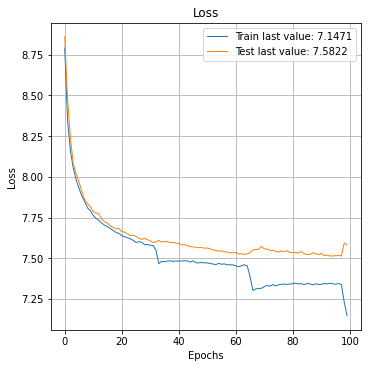

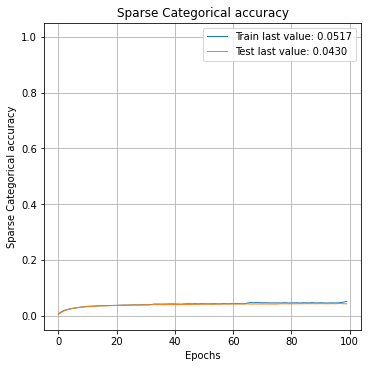

In [ ]:
plot_history(history, path="drive/MyDrive/graphs", single_graphs=True)
plt.close()

# Making predictions for each customer

In [ ]:
ys = []
ids = []
ps = []

id_encoder = encoders["article_id"]
cust_encoder = encoders["customer_id"]
customer_id = []
prediction = []

art_train = []
type_train = []
app_train = []
colour_train = []
dep_train = []
price_train = []

age_train = []
zip_train = []

y_train = []
custs = []

df = pd.DataFrame()
    
count = 0
rand_list = np.random.randint(low=0, high=customer_id_dim, size=1)
rand_articles = range(article_id_dim)
articles_list = []
customers = []  

for cust_num in range(1371980):

    count += 1
        
    # if count % 1000 == 0:
    #     print("Count is: ", cust_num)

    if (cust_num in articles_lists.index) and (len(articles_lists.loc[cust_num]) != 0):
      art_set = articles_lists.loc[cust_num]
      type_set = type_lists.loc[cust_num]
      app_set = appearance_lists.loc[cust_num]
      colour_set = colour_lists.loc[cust_num]
      dep_set = department_lists.loc[cust_num]
      price_set = price_lists.loc[cust_num]
      age = age_dict[cust_num]
      zip = zip_dict[cust_num]

      if len(set([len(art_set), len(type_set), len(app_set), len(colour_set), len(dep_set)])) != 1:
        print(cust_num)

    else:
      art_set = [article_id_dim]*max_input_len
      type_set = [product_type_dim]*max_input_len
      app_set = [appearance_dim]*max_input_len
      colour_set = [colour_dim]*max_input_len
      dep_set = [department_dim]*max_input_len
      price_set = [0]*max_input_len
      age = age_dict[cust_num]
      zip = zip_dict[cust_num]

    art_copy = art_set.copy()
    type_copy = type_set.copy()
    app_copy = app_set.copy()
    colour_copy = colour_set.copy()
    dep_copy = dep_set.copy()
    price_copy = price_set.copy()


    if len(art_copy) < max_input_len:
      art_copy = [article_id_dim]*(max_input_len - len(art_copy)) + list(art_copy)
      type_copy = [product_type_dim]*(max_input_len - len(type_copy)) + list(type_copy)
      app_copy = [appearance_dim]*(max_input_len - len(app_copy)) + list(app_copy)
      colour_copy = [colour_dim]*(max_input_len - len(colour_copy)) + list(colour_copy)
      dep_copy = [department_dim]*(max_input_len - len(dep_copy)) + list(dep_copy)
      price_copy = [0]*(max_input_len - len(price_copy)) + list(price_copy)
    elif len(art_copy) > max_input_len:
      idxs = random.sample(range(len(art_copy)), max_input_len)
      art_copy = list(map(art_copy.__getitem__, idxs))
      type_copy = list(map(type_copy.__getitem__, idxs))
      app_copy = list(map(app_copy.__getitem__, idxs))
      colour_copy = list(map(colour_copy.__getitem__, idxs))
      dep_copy = list(map(dep_copy.__getitem__, idxs))
      price_copy = list(map(price_copy.__getitem__, idxs))


    art_train.append(art_copy)
    type_train.append(type_copy)
    app_train.append(app_copy)
    colour_train.append(colour_copy)
    dep_train.append(dep_copy)
    price_train.append(price_copy)

    age_train.append([age])
    zip_train.append([zip])

In [34]:
import time

print(np.array(art_train).shape)

art_subsets = np.array_split(np.array(art_train), 200)
type_subsets = np.array_split(np.array(type_train), 200)
app_subsets = np.array_split(np.array(app_train), 200)
colour_subsets = np.array_split(np.array(colour_train), 200)
dep_subsets = np.array_split(np.array(dep_train), 200)
price_subsets = np.array_split(np.array(price_train), 200)
age_subsets = np.array_split(np.array(age_train), 200)
zip_subsets = np.array_split(np.array(zip_train), 200)

start = time.time()
customers_str = cust_encoder.inverse_transform(range(customer_id_dim))
end = time.time()

customer_id = []
prediction = []

print(end-start)

print(customers_str.shape)


(1371980, 16)
0.21239519119262695
(1371980,)


In [37]:
def extend(input_string):
  input_string = input_string.ljust(10, "0")
  return input_string

In [42]:
count = 0
row_count = 0

custs_list = []
preds_list = []


for i in range(200):
  cur_art = np.squeeze(tf.convert_to_tensor([art_subsets[i]]))
  cur_type = np.squeeze(tf.convert_to_tensor([type_subsets[i]]))
  cur_app = np.squeeze(tf.convert_to_tensor([app_subsets[i]]))
  cur_colour = np.squeeze(tf.convert_to_tensor([colour_subsets[i]]))
  cur_dep = np.squeeze(tf.convert_to_tensor([dep_subsets[i]]))
  cur_price = np.squeeze(tf.convert_to_tensor([price_subsets[i]]))
  cur_age = np.array([age_subsets[i]]).reshape(age_subsets[i].shape)
  cur_zip = np.array([zip_subsets[i]]).reshape(zip_subsets[i].shape)

  count += 1

  preds = model.predict([cur_art, cur_type, cur_app, cur_colour, cur_dep, cur_price, cur_age, cur_zip], verbose=0, batch_size=64)
  ind = np.argpartition(preds, -12)[:,-12:]
  ind[ind==pred_len] = most_common

  for row in range(ind.shape[0]):
    row_count += 1
    # preds_str = ""

    preds_str = id_encoder.inverse_transform(ind[row,:])
    cust_str = customers_str[row_count-1]
    preds_str = [extend(str(x)) for x in preds_str]
    preds_str = "\n".join(preds_str) 

    custs_list.append(cust_str)
    preds_list.append(preds_str)

In [62]:
df = pd.DataFrame()
df["customer_id"] = custs_list
df["prediction"] = preds_list

print(df.shape)
df.to_csv("drive/MyDrive/transformer_preds.csv", index=False)

(1371980, 2)


# Showing transformer-based model results


Using this metric, my transformer-based model got 0.0034 MAP@12.  This isn't great.  For perspective, that places me at 2000th out of 2500 places on the current Kaggle competition leaderboard.

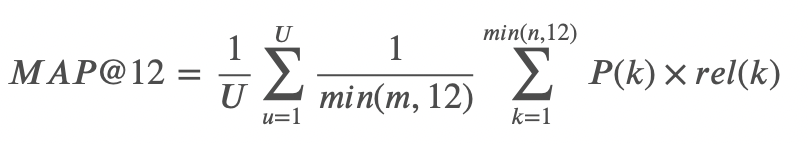

In [3]:
from IPython.display import Image
Image(filename='Screen Shot 2022-04-24 at 11.28.16 AM.png') 

# Transitioning from transformer based model to simple model.

This simpler model is designed just to train embeddings.  The embeddings will (hopefully) be some indicator of how likely a customer is to buy a product.  This probability will be generated from the trained embeddings by taking the dot product of the customer and article embeddings of interest, and then transforming the number output through a trained linear transformation followed by a sigmoid function.

Dropout is added to this model to help mitigate the risk of model overfitting.  I'm not entirely sure if it helped, or if it was even necessary.  The idea of embeddings overfitting seems a little bit odd to me.

If, for example, I was creating word embeddings, I essentially want my embeddings to memorize data about my text corpus in a dense way.  Given that the goal seems to me to be a form of memorization, I'm not sure that overfitting is actually bad in this case.  I think the customer and article embeddings may also not have an issue with overfitting for the same reason, though I'm not positive.

In [44]:
embed_size = 64
rate = .1

cust_inp = Input(shape=(1, ))
cust_emb = Embedding(customer_id_dim, embed_size,
                         input_length=1)(cust_inp)

dropout_1 = Dropout(rate, seed=1)(cust_emb)

cust_reshaped = Reshape((embed_size, 1))(dropout_1)

article_inp = Input(shape=(1, ))
article_emb = Embedding(article_id_dim, embed_size,
                  input_length=1)(article_inp)

dropout_2 = Dropout(rate, seed=1)(article_emb)

article_reshaped = Reshape((embed_size, 1))(article_emb)

dot = Dot(axes=(1,1))([cust_reshaped, article_reshaped])

dense = Dense(1, activation="sigmoid")(dot)

model = Model([cust_inp, article_inp], dense)

In [45]:
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["binary_accuracy","AUC"])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 1, 64)        87806720    ['input_9[0][0]']                
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dropout_2 (Dropout)            (None, 1, 64)        0           ['embedding_6[0][0]']            
                                                                                            

# Collecting data for training into one place

The transactions dataset currently has only purchased customer-product pairs.  This means that the above model architecture will learn to always predict a positive outcome, given any customer-product pair.  Obviously we don't want this.

To help fix this issue, for each customer, I've randomly chosen products that we'll pretend that customer isn't interested in.  For example, if the customer has previously purchased eight items, then I'll randomly select eight items that the customer has not purchased from the total set of items, and then pretend that we're certain that the customer is not interested in these items.  

That assumption will almost certainly be wrong occasionally, but given that we're randomly choosing a very small subset of the total number of options (10,000) I suspect it is a fine working assumption.

In [63]:
sample_count = 5
mcp_save = ModelCheckpoint('drive/MyDrive/mdl_wts.hdf5', save_best_only=True, monitor='loss', mode='min')
    
article_train = []
customer_train = []
y_train = []

count = 0
rand_list = np.random.randint(low=0, high=customer_id_dim, size=700000)

for cust_num in range(customer_id_dim):
    
    count += 1
    
    # if count % 1000 == 0:
    #     print("Count is: ", count)

    if cust_num in articles_lists.index:
      x = articles_lists.loc[cust_num]
      all_articles = set(range(article_id_dim))
      diff = tuple(all_articles - set(x))
      len_diff = len(diff)
      
      for i in range(len(x)):
          
          if len(x) != 0:
              article = [x[i]]
              customer = [cust_num]
              y = [1]

              article_train.append(np.array(article))
              customer_train.append(np.array(customer))
              y_train.append(y)

              article = [diff[int(len_diff * random.random())]]
              customer = [cust_num]
              y = [0]

              article_train.append(np.array(article))
              customer_train.append(np.array(customer))
              y_train.append(y)

          if len(x) == 0:
              print(cust_num)



article_train = np.array(article_train)
customer_train = np.array(customer_train)
y_train = np.array(y_train)

# Fitting simple embedding model

In [64]:
history = model.fit([customer_train, article_train], y_train, batch_size=4096, epochs=20, verbose=0)

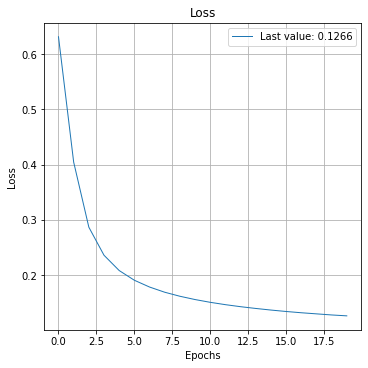

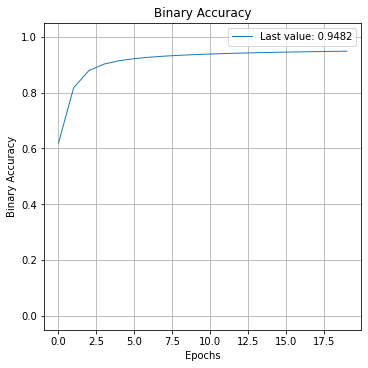

In [65]:
plot_history(history, path="drive/MyDrive/graphs_emb", single_graphs=True)
plt.close()

# Converting embeddings to product predictions

My strategy for converting my trained article embeddings and customer embeddings into predictions is to dot product each customer and article pair, and then transform that dot product using the fitted sigmoid function weights used as the final layer of the simple model.  

Then, I'll drop any article_ids that have previously been purchased by that customer, and then I'll select the top n most likely values (see n_values = 60).

Finally, out of those 60 values, I'll group by the department name of each product and select the 12 most likely values (but only one from each department.  I'm forcing my model to choose from multiple store departments so that I maximize the variance of my predictions.  I'm trying to avoid having all twelve of my predictions be just different colors of one product (t-shirts, for instance).

In [66]:
cust_embeddings = model.layers[1].get_weights()[0]
art_embeddings = model.layers[4].get_weights()[0]
print(cust_embeddings.shape)
print(art_embeddings.shape)

(1371980, 64)
(10000, 64)


In [67]:
cust_subsets = np.array_split(cust_embeddings, 100)

In [87]:
start = time.time()
count = 1
n_values = 60
n_partitions = 12
final_preds = []

inds_list = []
preds_list = []
customer_list = []
department_list = []

weights = model.layers[8].get_weights()[0][0][0]
biases = model.layers[8].get_weights()[1][0]

def sig(x):
  return np.exp(x) / (1+np.exp(x))

def final_layer(x):
  return sig(weights*x + biases)

print(weights, biases)

for array in cust_subsets:

  indices = []

  ids = [x for x in articles_lists.index if (x < array.shape[0]*count) and (x >= array.shape[0]*(count-1))]
  
  for i in ids:
    indices += [[i % array.shape[0], x] for x in list(set(articles_lists.loc[i]))]
    # if i % 10000 == 0:
    #   print(i)

  indices = np.array(indices)

  pred = final_layer(np.matmul(array, art_embeddings.T))
  pred[tuple(indices.T)] = 0
  ind = np.argpartition(pred, -n_values)[:,-n_values:]
  preds = np.take_along_axis(pred, ind, axis=1).flatten()

  for cust_id in range((count-1)*array.shape[0], count*array.shape[0]):
    customer_list += n_values*[cust_id]

  inds_list += list(ind.flatten())
  preds_list += list(preds)
  department_list += list(articles.loc[ind.flatten()]["department_no"].values)

  count += 1

2.4522662 -1.669735


In [88]:
start = time.time()

df = pd.DataFrame()
df["inds"] = inds_list
df["rank"] = preds_list
df["group"] = department_list
df["id"] = customer_list

end = time.time()

print(end-start)

120.79200720787048


In [89]:
chosen = df.sort_values("rank", ascending=False).groupby(["id", "group"], sort=False, as_index=False).first()
chosen.shape

(27805419, 4)

In [90]:
chosen_twelve = chosen.groupby(["id"], as_index=False).head(12)
chosen_twelve.shape

(16036357, 4)

In [91]:
chosen_list = chosen_twelve.groupby(['id'])['inds'].apply(list)

In [92]:
chosen_list.head()

id
0    [1845, 8236, 5694, 6762, 4675, 5877, 9632, 686...
1    [3073, 5434, 7219, 1, 2211, 4770, 2931, 2346, ...
2    [7254, 1688, 8488, 8203, 9553, 2974, 8255, 875...
3       [5794, 5265, 503, 7412, 1794, 5472, 461, 1896]
4    [4088, 4384, 4635, 5289, 4285, 9597, 4264, 294...
Name: inds, dtype: object

# Formatting customer_id and predictions for submission to Kaggle

In [93]:
custs = []
preds = []

customers_str = cust_encoder.inverse_transform(range(customer_id_dim))
print(len(customers_str))
indices_set = set(chosen_list.index)

for idx in range(len(customers_str)):
  if idx in indices_set:
    preds_str = encoders["article_id"].inverse_transform(chosen_list.loc[idx])
    cust_str = customers_str[idx]
    preds_str = [extend(str(x)) for x in preds_str]
    preds_str = "\n".join(preds_str)

    custs.append(cust_str)
    preds.append(preds_str)

  else:
    cust_str = customers_str[idx]
    preds.append(preds_str)
    custs.append(cust_str)

1371980


# Saving predictions from simple model

In [94]:
df = pd.DataFrame()
df["customer_id"] = custs
df["prediction"] = preds

print(df.shape)

df.to_csv("drive/MyDrive/preds.csv", index=False)

(1371980, 2)


# Showing simple model results

Using this metric, my simple model got 0.000 MAP@12.

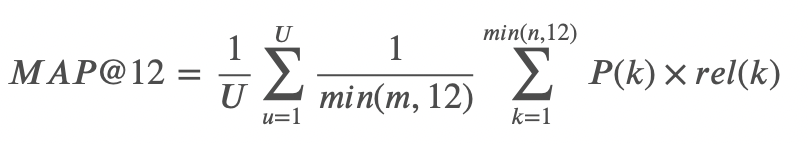

In [4]:
Image(filename='Screen Shot 2022-04-24 at 11.28.16 AM.png') 

# Attempting to visualize embeddings in 2D using PCA

In [95]:
from sklearn.decomposition import PCA

col = transactions.groupby(["customer_id"]).first()[transactions["customer_id"].isin(set(rand_list))]["product_type_name"]
print(col.shape)

print(art_embeddings.shape)

pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(art_embeddings)

print(pca.explained_variance_ratio_)

df = pd.DataFrame(embeddings_pca, columns=["emb_1", "emb_2"])
df["product_type"] = col

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(486421,)
(10000, 64)
[0.03206388 0.02992618]


In [96]:
df.head()

,emb_1,emb_2,product_type
0,2.291836,-0.177902,6.0
1,1.889428,-0.224657,61.0
2,0.112877,-0.264501,5.0
3,-0.126311,-0.105827,10.0
4,1.067837,0.957382,7.0


### As can be seen from the plot below, no clear patterns emerge when compressing 64 dimensions down into 2.  This is unsurprising, but also a little dissappointing.  If I create 2 dimensional embeddings, a few simple patterns emerge, but given that this is a completely unrealisting embedding dimension I haven't included that plot.

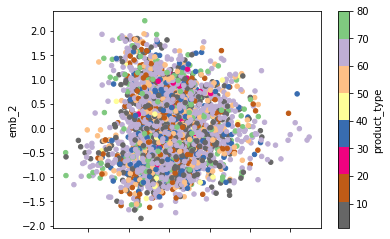

In [97]:
sample = df.sample(n=10000)

sample.plot.scatter(x='emb_1',
                y='emb_2',
                c='product_type',
                colormap="Accent_r")